## **Análise Exploratória e Pré-processamento dos Dados**
Aqui serão realizadas análises preliminares dos dados, como estatísticas, decomposição para análise de tendência, sazonalidade e resíduo das séries. Posteriormente, os dados serão separados em treino e teste para as próximas etapas do projeto: **_engenharia de características_**, **_modelagem_** e **_comparação dos resultados_**.

In [12]:
# preparação do notebook
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from utilsforecast.preprocessing import fill_gaps

# módulos locais
from src.features import decompose
from src.outliers import detect_outliers
from src.plots import plot_time_series
from src.utils import ts_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import string
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# leitura dos dados brutos
df1 = pd.read_csv(
    "../data/data.csv", parse_dates=['ds'], index_col=[0]
)

# preenchendo os dados com os dias ausentes
df1 = fill_gaps(
    df=df1,
    freq='D',
    start='global',
    end='per_serie'
).fillna(0)

# skus que serão analisados e modelados
SKUS = ['SKU_02', 'SKU_03', 'SKU_04', 'SKU_12'] 

df = df1[df1['unique_id'].isin(SKUS)].reset_index(drop=True)
df['unique_id'] = df['unique_id'].replace(
    {'SKU_02': 'SKU_01', 
     'SKU_03': 'SKU_02', 
     'SKU_04': 'SKU_03', 
     'SKU_12': 'SKU_04'}
)

In [14]:
# estatísticas descritivas
df.groupby("unique_id")['y'].describe().iloc[:,1:].to_csv('../data/estatisticas.csv', sep=';', decimal=',')
df.groupby("unique_id")['y'].describe()

,count,mean,std,min,25%,50%,75%,max
unique_id,,,,,,,,
SKU_01,2088.00,271.55,205.25,0.00,66.00,265.00,431.00,1350.00
SKU_02,2088.00,61.24,48.57,0.00,15.00,53.00,102.00,242.00
SKU_03,2088.00,47.15,35.64,0.00,11.00,51.00,75.00,406.00
SKU_04,2088.00,81.45,55.58,0.00,22.00,88.00,126.00,257.00


## **Visualização dos Dados**

In [15]:
# definindo configurações padrão
colors = ["#cb5b89", "#db91b3", "#f8cb69", "#329b99", '#d8e9ea'][::-1]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)

plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.dpi'] = 150

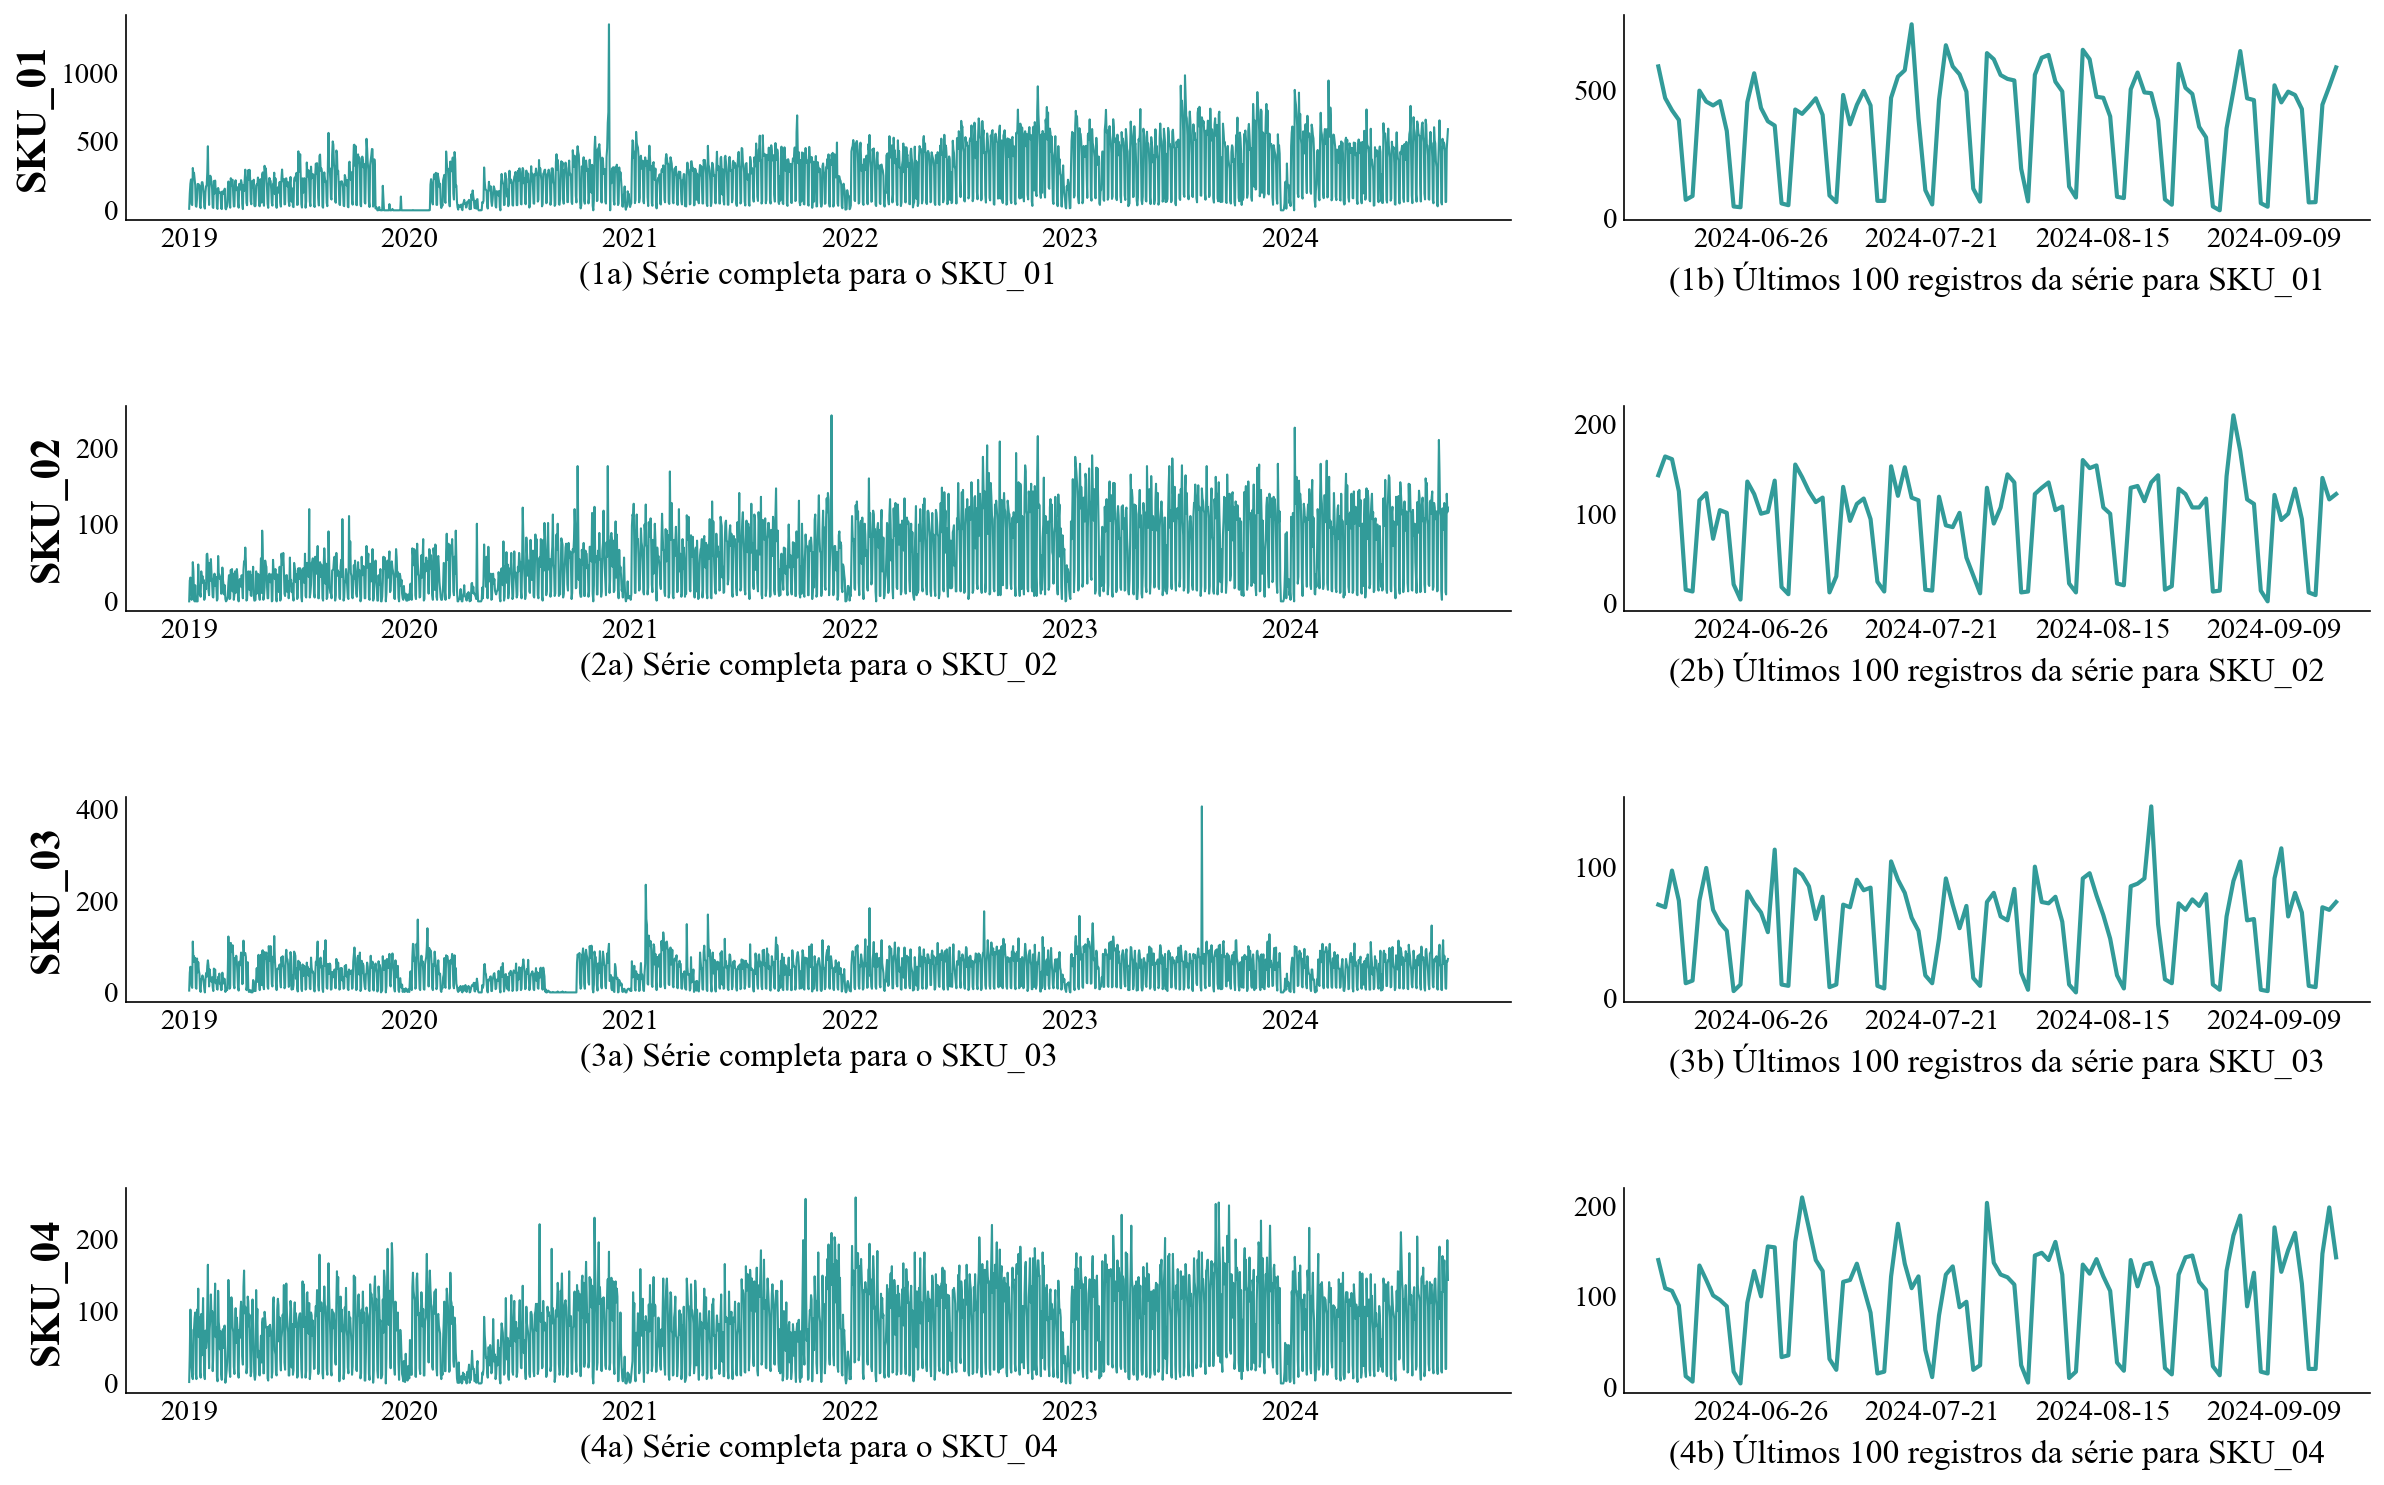

In [16]:
fig, ax = plt.subplots(
    nrows=len(SKUS), ncols=2, figsize=(16, 10), gridspec_kw={'width_ratios': [65, 35]},
)  
letters = string.ascii_lowercase
kwgs = dict(
    x='ds', y='y', color=colors[1]
)
for i, sku in enumerate(df.unique_id.unique()):

    major_df = df[df['unique_id'] == sku]
    minor_df = df[df['unique_id'] == sku].iloc[-100:]
    sns.lineplot(major_df, ax=ax[i, 0], lw=1, **kwgs)
    sns.lineplot(minor_df, ax=ax[i, 1], lw=2, **kwgs)

    ax[i, 0].set_ylabel(sku, fontsize=20, weight='bold')
    ax[i, 1].set_ylabel(None)
    ax[i, 0].set_xlabel(f'({i+1}{letters[0]}) Série completa para o {sku}', fontsize=16)
    ax[i, 1].set_xlabel(f'({i+1}{letters[1]}) Últimos 100 registros da série para {sku}', fontsize=16)

    for axs in (ax[i, 0], ax[i, 1]):
        for j, spine in enumerate(axs.spines.values()):
            if j % 2 != 0:
                spine.set_visible(False)
        
        axs.tick_params(axis='x', labelsize=14, size=0, left=True)
        axs.tick_params(axis='y', labelsize=14, size=0)
    ax[i, 1].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
fig.tight_layout(h_pad=5, w_pad=3)
plt.show()


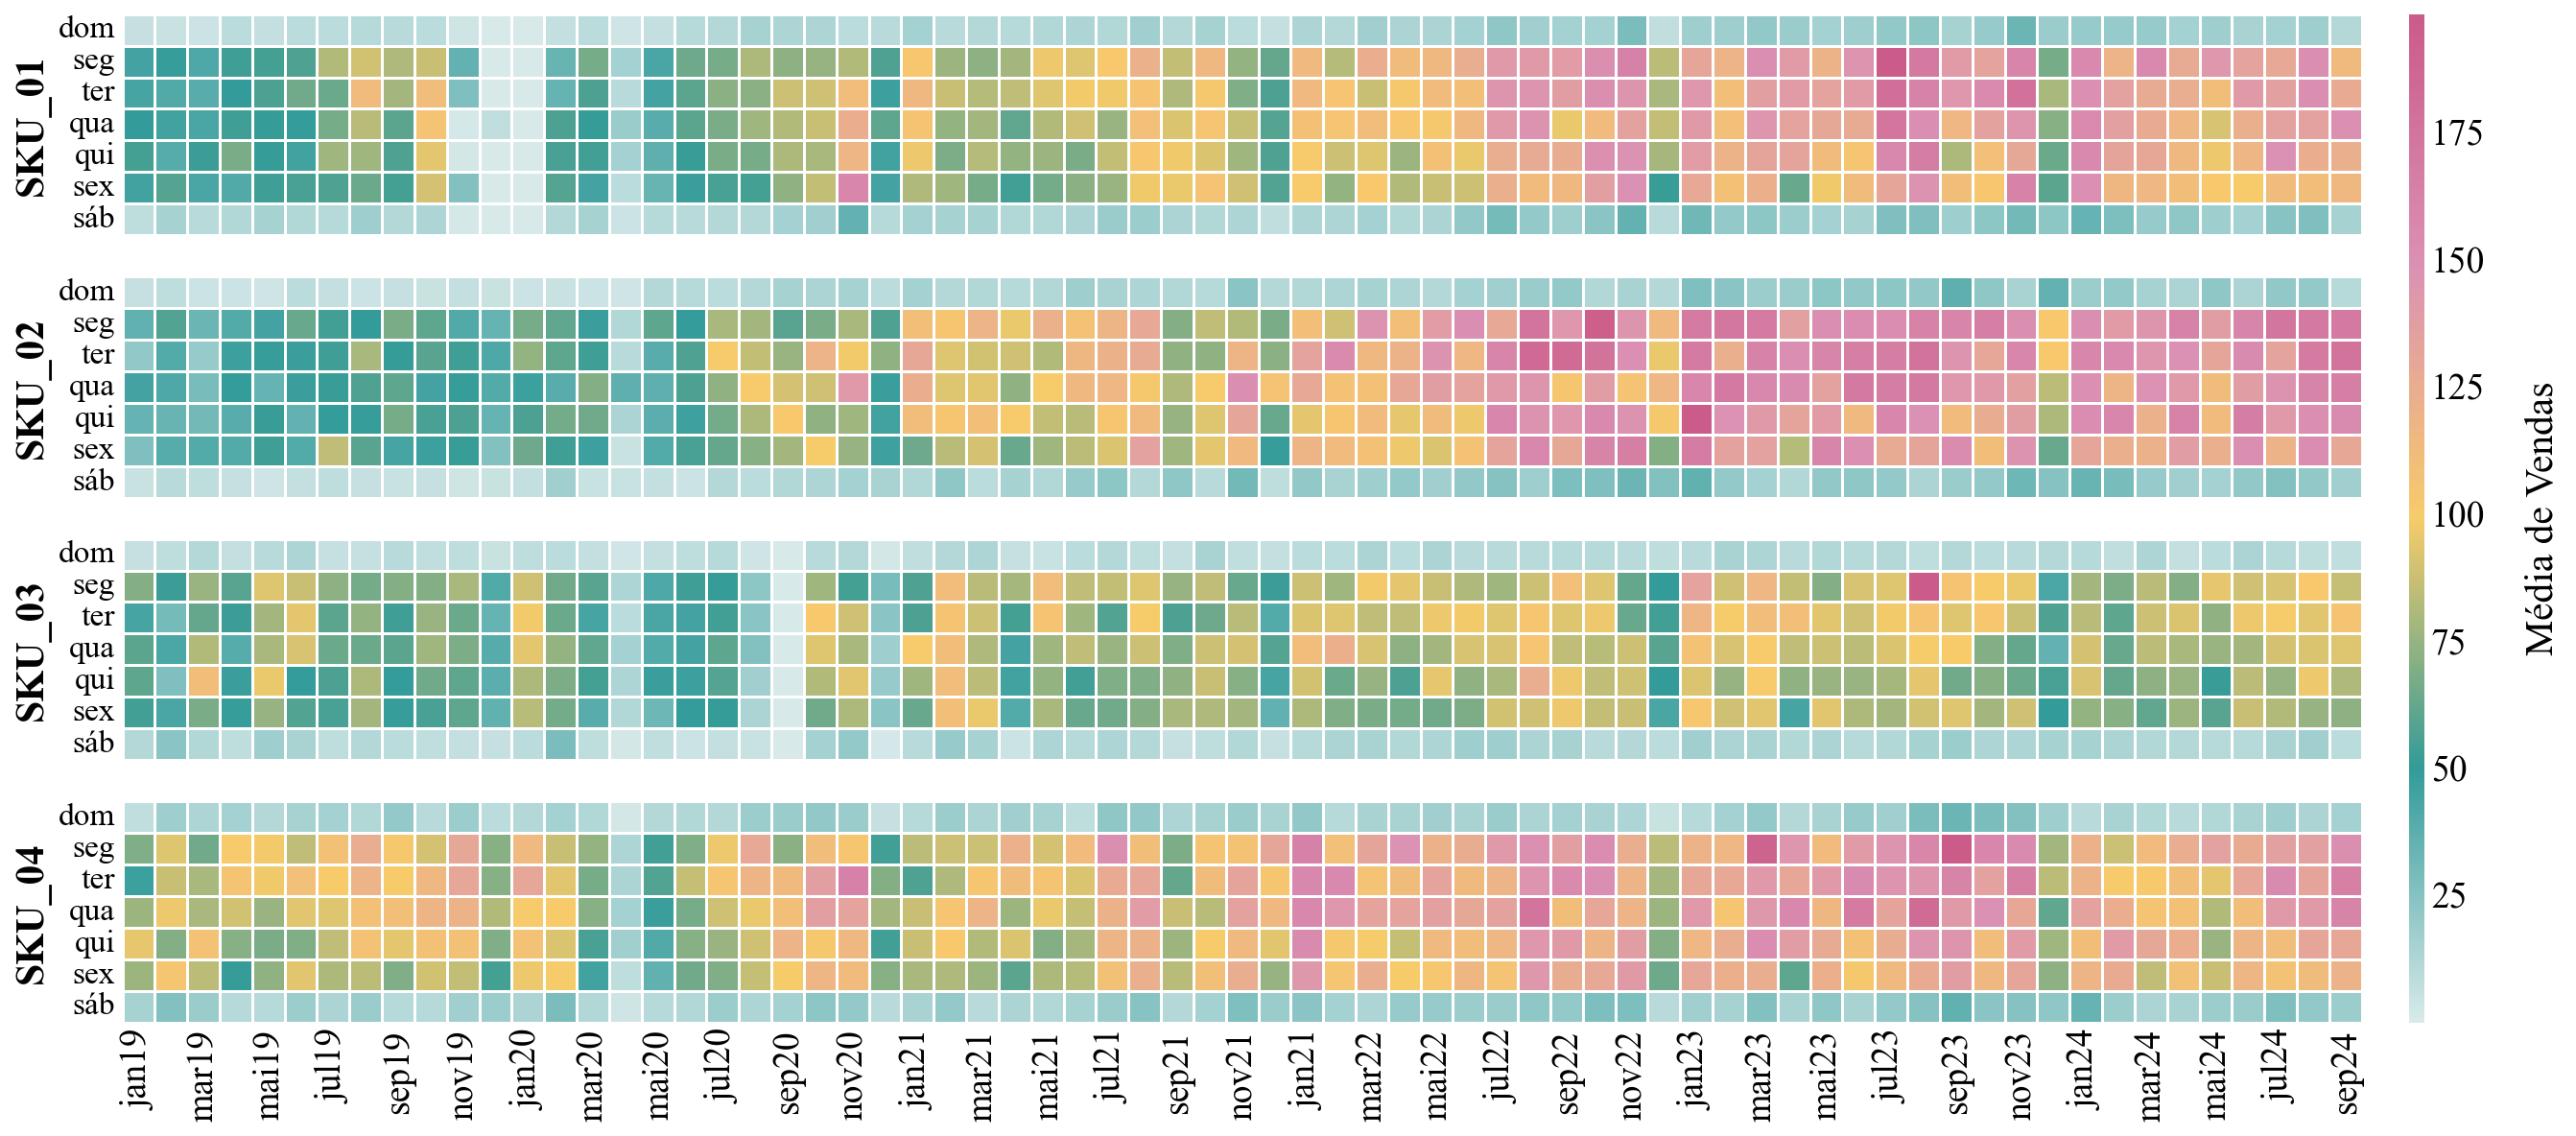

In [17]:
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(len(SKUS), 2, width_ratios=[150, 1])

axes = []
for i, sku in enumerate(df.unique_id.unique()):
    ax = plt.subplot(gs[i, 0])
    axes.append(ax)

    df2 = df[df['unique_id'] == sku].reset_index(drop=True)
    df2['year'] = df2.ds.dt.year
    df2['month'] = df2.ds.dt.month
    df2['Mês'] = df2.ds.dt.month_name('pt').str[:3]
    df2['Dia da Semana'] = df2.ds.dt.day_name('pt').str[:3]
    df2['Dia da Semana'] = df2['Dia da Semana'].str.lower()
    df2['day_of_week'] = df2.ds.dt.dayofweek + 1
    df2.loc[df2['day_of_week'] == 7, 'day_of_week'] = 0

    heatmap = sns.heatmap(
        df2.pivot_table(
            values='y',
            index=['day_of_week', 'Dia da Semana'],
            columns=['year', 'month','Mês'],) \
        .droplevel(axis=1, level=1) \
        .droplevel(axis=0, level=0),
        cmap=custom_cmap,
        linecolor='white', 
        linewidths=0.5,
        ax=ax, 
        cbar=False,  
        vmin=0.01
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xlabel(None)
    ax.set_ylabel(sku, fontsize=20, weight='bold')
    ax.tick_params(axis='x', labelsize=16, size=0)
    ax.tick_params(axis='y', labelsize=16, size=0)

    if i == len(SKUS)-1:
        meses = [
            'jan19', None, 'mar19', None, 'mai19', None, 'jul19', None, 'sep19', None, 'nov19', None,
            'jan20', None, 'mar20', None, 'mai20', None, 'jul20', None, 'sep20', None, 'nov20', None,
            'jan21', None, 'mar21', None, 'mai21', None, 'jul21', None, 'sep21', None, 'nov21', None,
            'jan21', None, 'mar22', None, 'mai22', None, 'jul22', None, 'sep22', None, 'nov22', None,
            'jan23', None, 'mar23', None, 'mai23', None, 'jul23', None, 'sep23', None, 'nov23', None,
            'jan24', None, 'mar24', None, 'mai24', None, 'jul24', None, 'sep24'
        ]

        ax.set_xticks(range(len(meses)))
        ax.set_xticklabels(meses, fontsize=18, ha="left")
    else:
        ax.set_xticks([])


# cbar na coluna secundária
cbar_ax = plt.subplot(gs[:, 1])
cbar = fig.colorbar(heatmap.get_children()[0], cax=cbar_ax)
cbar.ax.tick_params(labelsize=18, size=0)
cbar.ax.set_ylabel("Média de Vendas", fontsize=20, labelpad=20)
cbar.outline.set_visible(False)


fig.tight_layout(h_pad=2, w_pad=2)
plt.show()
fig.add_artist(
    plt.Line2D(
        [1, 10], 
        [0, 100],
        transform=fig.transFigure,
        color='red',
        linewidth=10
    )
)

In [18]:
df['month'] = df.ds.dt.month
df["Mês"] = df["ds"].dt.month_name('pt').str[:3]
df['day_of_week'] = df.ds.dt.dayofweek
df["Dia da Semana"] = df["ds"].dt.day_name('pt').str[:3]
skus = df.unique_id.unique()
monthly_avg = df.groupby(["unique_id", "month", "Mês"], as_index=False)["y"].mean()
weekly_avg = df.groupby(["unique_id", "day_of_week", "Dia da Semana"], as_index=False)["y"].mean()

monthly_avg = monthly_avg.pivot_table(
    values='y',
    index='unique_id',
    columns=['month', 'Mês'],
).droplevel(axis=1, level=0)

weekly_avg = weekly_avg.pivot_table(
    values='y',
    index='unique_id',
    columns=['day_of_week', 'Dia da Semana'],
    # columns=['year', 'month','Mês'],
).droplevel(axis=1, level=0)

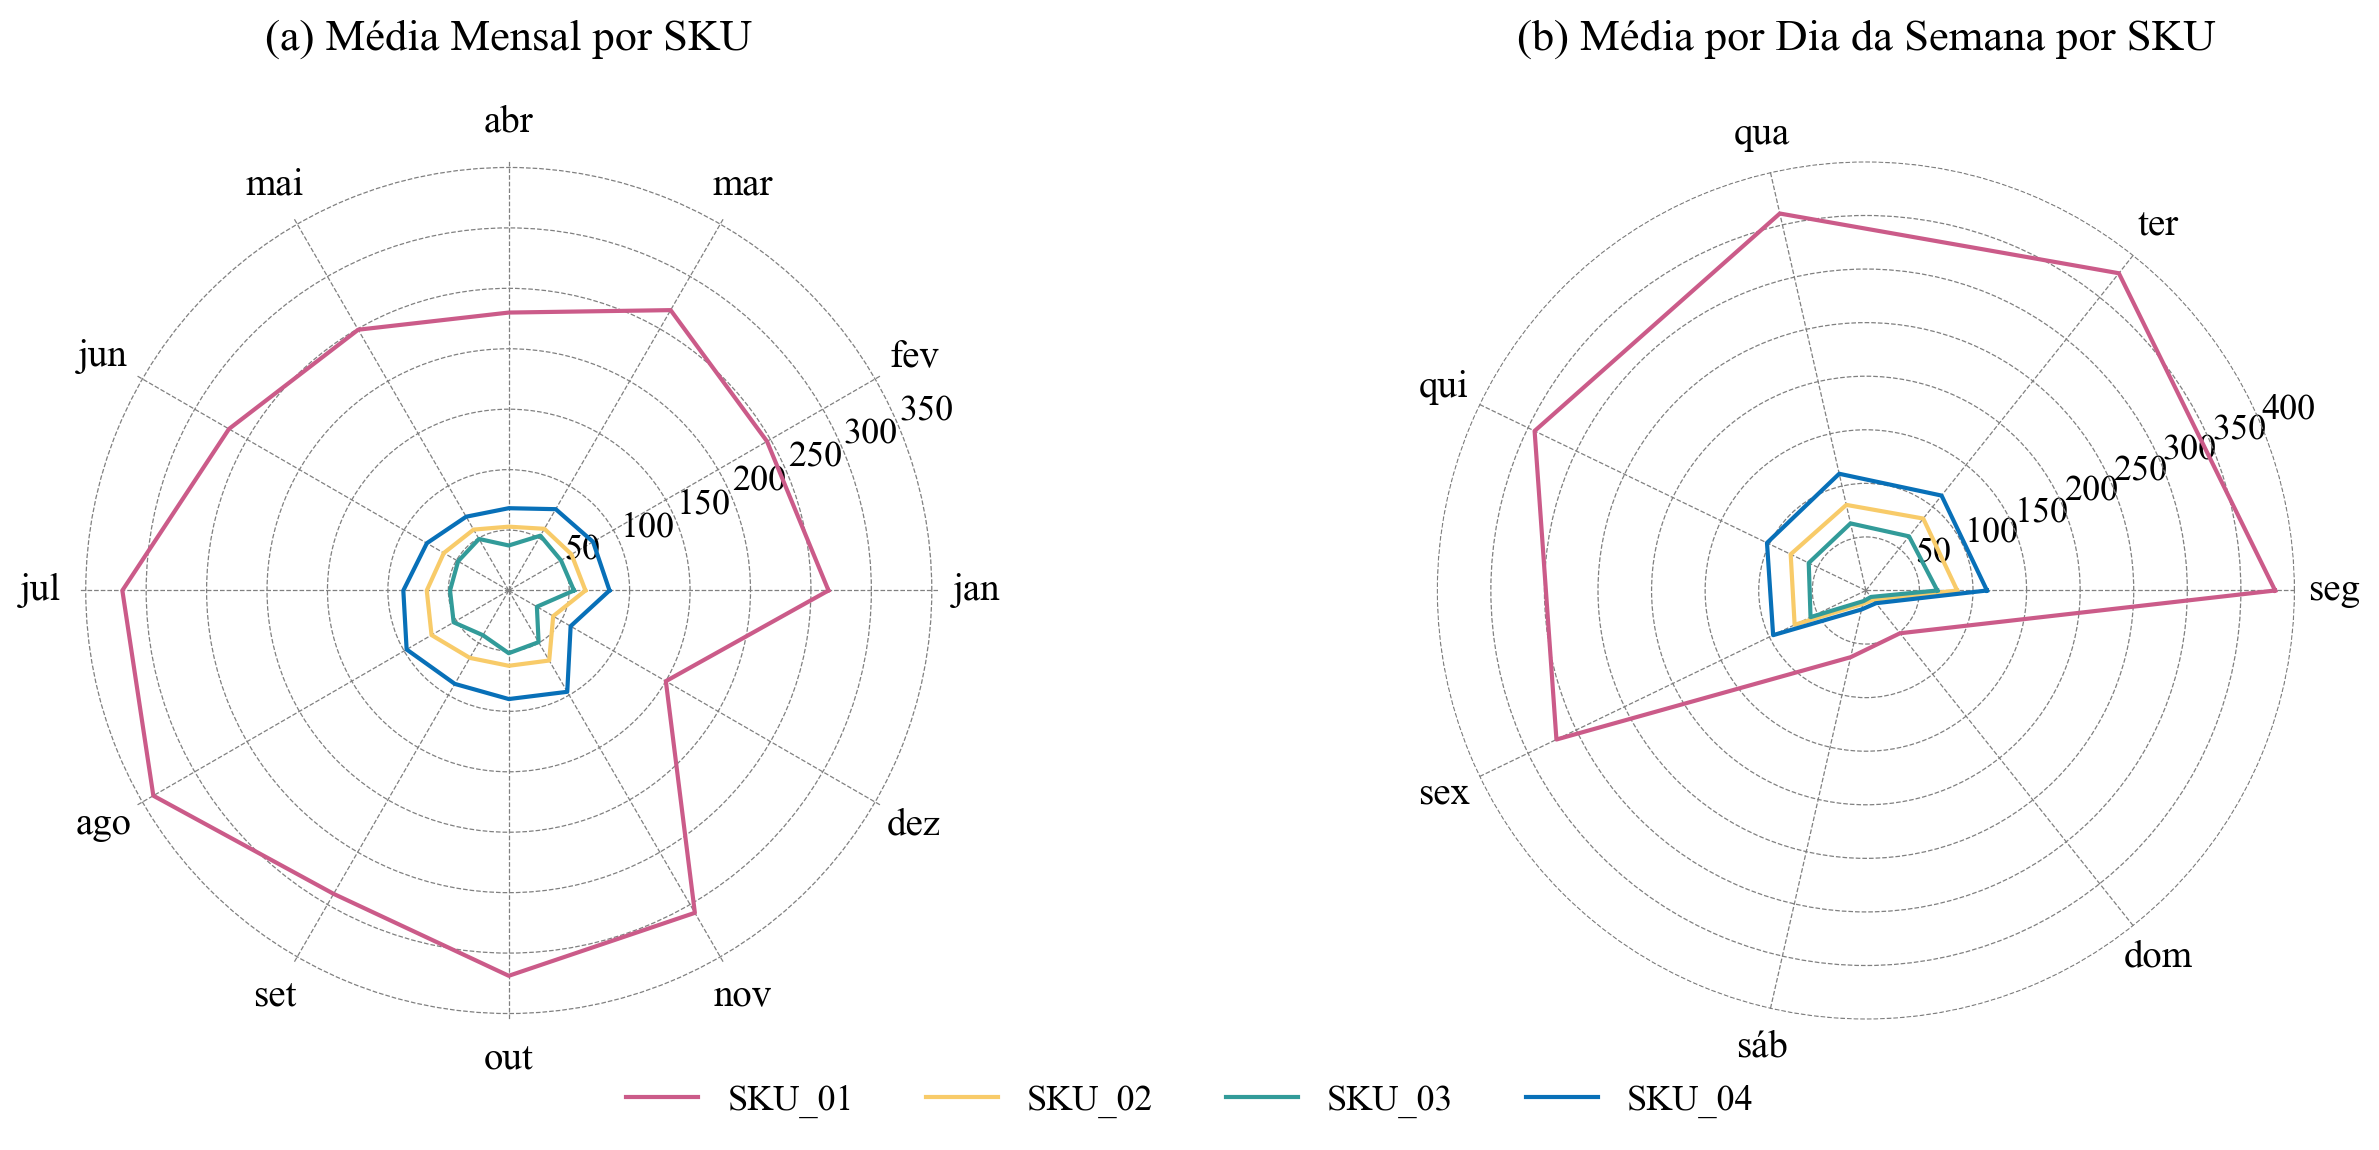

In [19]:
month_angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)
week_angles = np.linspace(0, 2 * np.pi, 7, endpoint=False)

colors = ["#cb5b89", "#f8cb69", "#329b99", '#0870b8']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True), dpi=200)

for i, sku in enumerate(skus):
    valores = monthly_avg.loc[sku].tolist() + [monthly_avg.loc[sku].tolist()[0]]
    angs = month_angles.tolist() + [month_angles[0]]
    axes[0].plot(angs, valores, label=sku, color=colors[i], linewidth=1.5)

axes[0].set_xticks(month_angles)
axes[0].set_xticklabels(["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"], fontsize=14)
axes[0].set_title("(a) Média Mensal por SKU", fontsize=16, pad=40)

for i, sku in enumerate(skus):
    valores = weekly_avg.loc[sku].tolist() + [weekly_avg.loc[sku].tolist()[0]]
    angs = week_angles.tolist() + [week_angles[0]]
    axes[1].plot(angs, valores, label=sku, color=colors[i], linewidth=1.5)

axes[1].set_xticks(week_angles)
axes[1].set_xticklabels(["seg", "ter", "qua", "qui", "sex", "sáb", "dom"], fontsize=14)
axes[1].set_title("(b) Média por Dia da Semana por SKU", fontsize=16, pad=40)

for ax in axes:
    ax.spines['polar'].set_visible(False)
    ax.grid(color='gray', linestyle='--', linewidth=0.45)
    ax.yaxis.set_tick_params(labelsize=13)
    
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')  # centraliza

legend = fig.legend(
    ['SKU_01', 'SKU_02', 'SKU_03', 'SKU_04'], 
    loc=' outside lower center', ncol=4, fontsize=13, 
)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

plt.tight_layout(w_pad=15)
plt.show()

## **Decomposição das Séries**
Séries temporais podem ser decompostas em padrões ou componentes separados, como tendência (podendo ser linear ou não), sazonalidade (ciclos que se repetem a cada semana, mês ou ano, por exemplo), de modo que uma série temporal pode ser definida pela seguinte forma:
$$
y_t = T_t + S_t + R_t
$$

onde $y_t$ é valor observado, $T_t$ é a tendência $S_t$ é o componente sazonal, $R_t$ é o resíduo, todos observados no tempo $t$.


In [20]:
# decompondo as séries
decomposed_df = decompose(df)

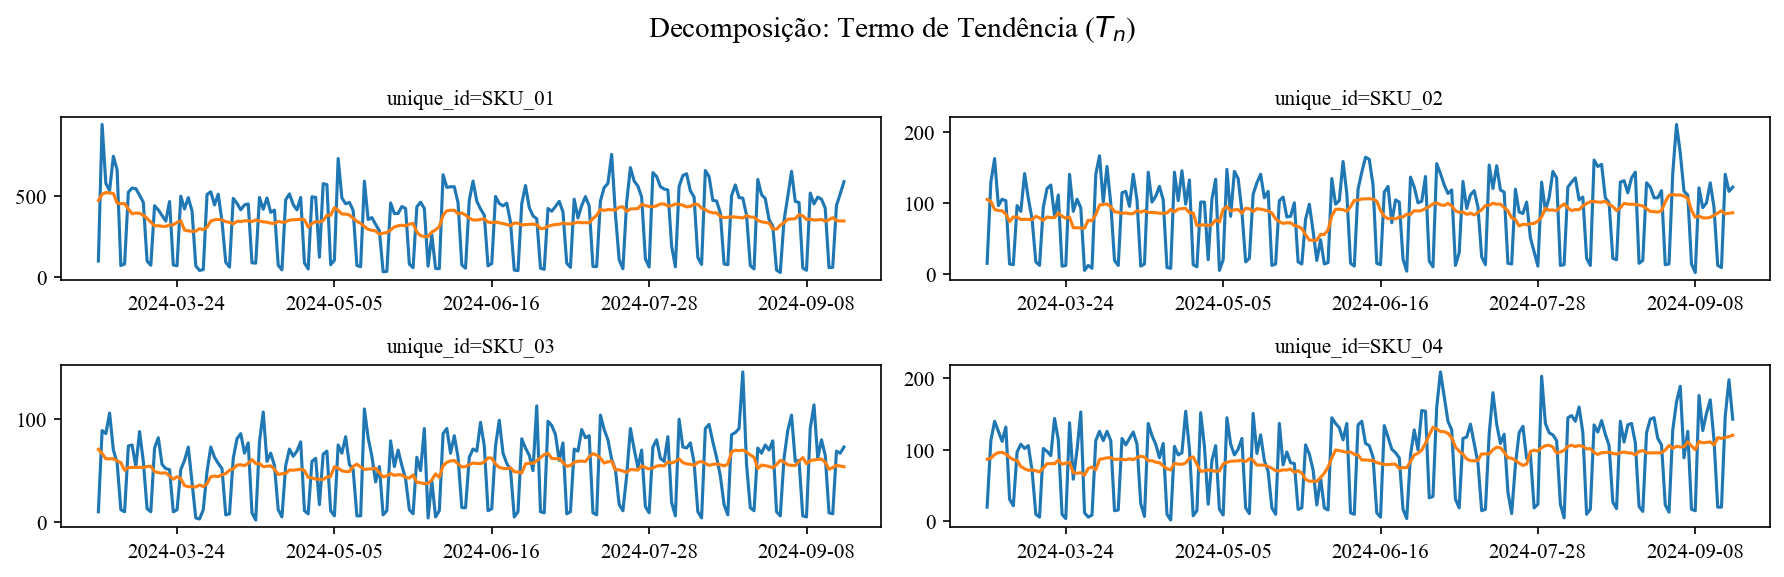

In [21]:
# plot das séries com a tendência baseada em média móvel
fig3 = plot_time_series(
    df=decomposed_df,
    data_cols=['y', 'trend'],
    figsize=(12, 4),
    n_max=200,
    title='Decomposição: Termo de Tendência ($T_n$)'
)

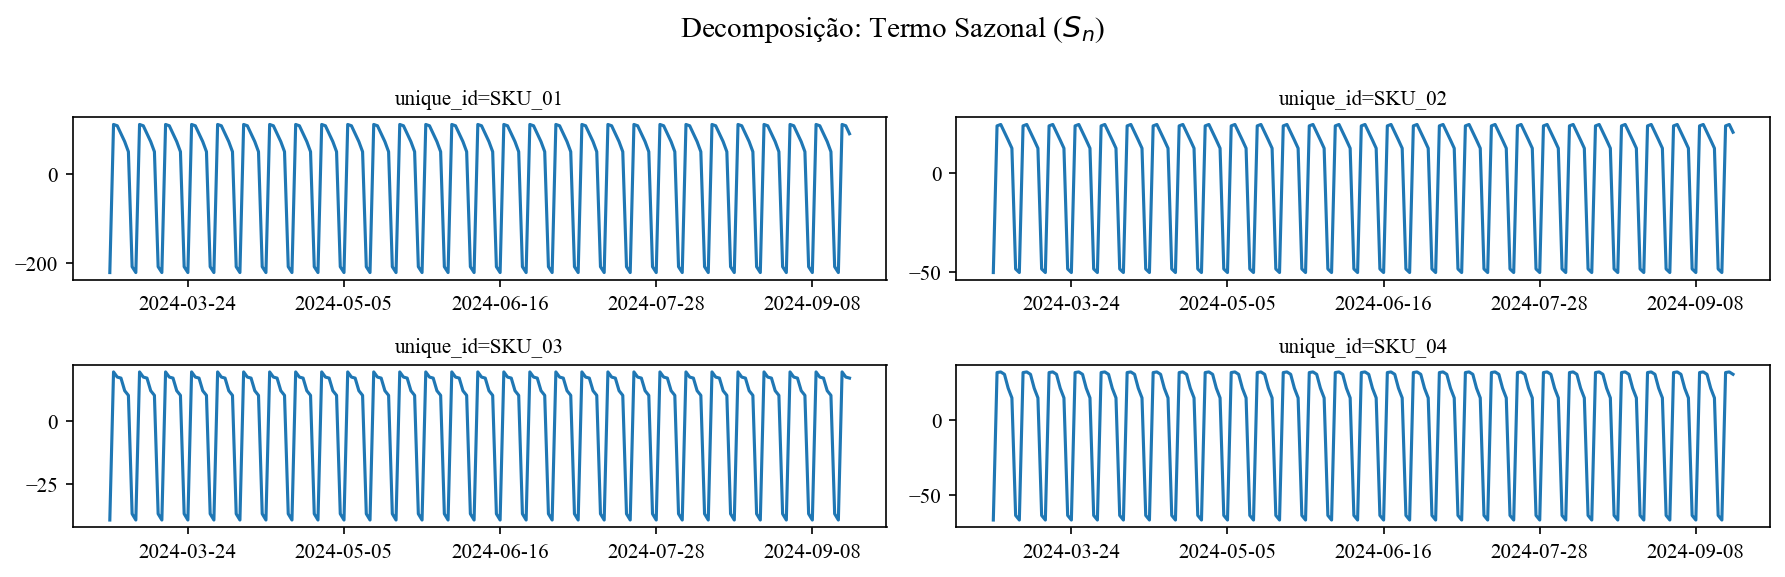

In [22]:
# plot do termo sazonal da série
fig4 = plot_time_series(
    decomposed_df,
    data_cols=['seasonal'],
    figsize=(12, 4),
    n_max=200,
    title='Decomposição: Termo Sazonal ($S_n$)'
)

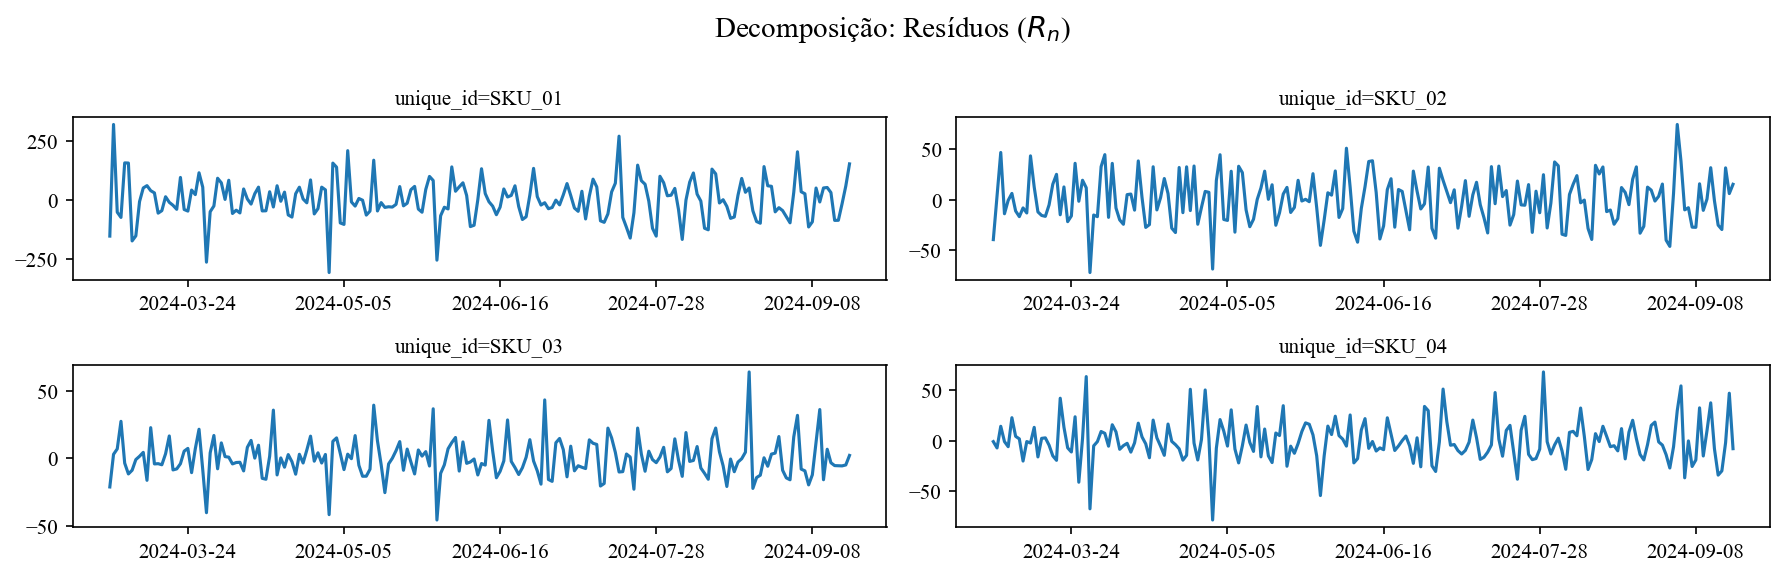

In [23]:
# plot dos resíduos da decomposição
fig5 = plot_time_series(
    decomposed_df,
    data_cols=['resid'],
    figsize=(12, 4),
    n_max=200,
    title='Decomposição: Resíduos ($R_n$)'
)

## **Dados de Treino e Teste**
Para os experimentos, serão utilizados 80% de cada série para treinar os modelos, e o restante dos dados para avaliar suas performances.

In [24]:
# dividindo dados em treino e teste
train_df, test_df = ts_train_test_split(df=df, test_size =365, id_col='unique_id')

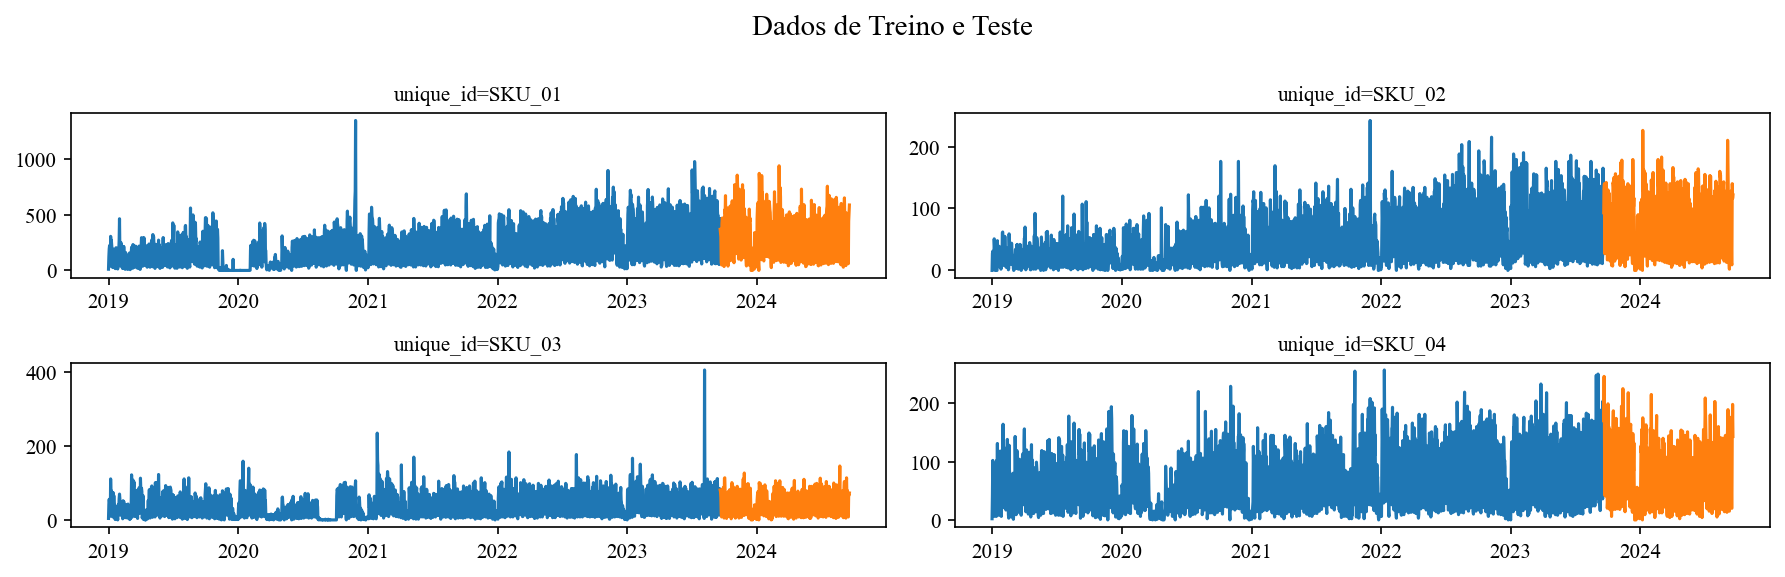

In [25]:
# visualizando split
fig7 = plot_time_series(
    df=train_df.merge(test_df, how='outer', on=['unique_id', 'ds'], suffixes=['_train','_test']),
    data_cols=['y_train', 'y_test'],
    title='Dados de Treino e Teste',
    figsize=(12, 4)
)

## **Outliers**
Para identificação e tratamento de outliers em séries temporais existem diversas técnicas, como identificação visual ou $1.5*IQR$. Aqui, utilizaremos o método de ESD (extreme Studentized deviate) [[1]](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm), que aplica teste de Grubbs [[2]](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h1.htm) sequencialmente até que o critério de parada ($G < $ *Região Crítica* | $\alpha$) seja atingido.
Serão aplicados os testes para valores mínimos e máximos nos resíduos da decomposição das séries temporais, seguindo a proposta do modelo **Seasonal-ESD** em **_Automatic Anomaly Detection in the Cloud
 Via Statistical Learning_** [[3]](https://arxiv.org/abs/1704.07706).
 
 Os resultados serão usados como inputs para os modelos como variáveis explicativas (**_max_outliers_** e **_min_outliers_**), onde 1 equivale a valores considerado outliers e 0 valores normais.
 Para os dados de teste, todos os valores serão marcados como 0, evitando vazamento de informação.

In [26]:
# detecção de outliers usando Seasonal-ESD
outliers_df = detect_outliers(df=train_df)
outliers_df.filter(like='outliers').sum()

max_outliers   31.00
min_outliers   39.00
dtype: float64

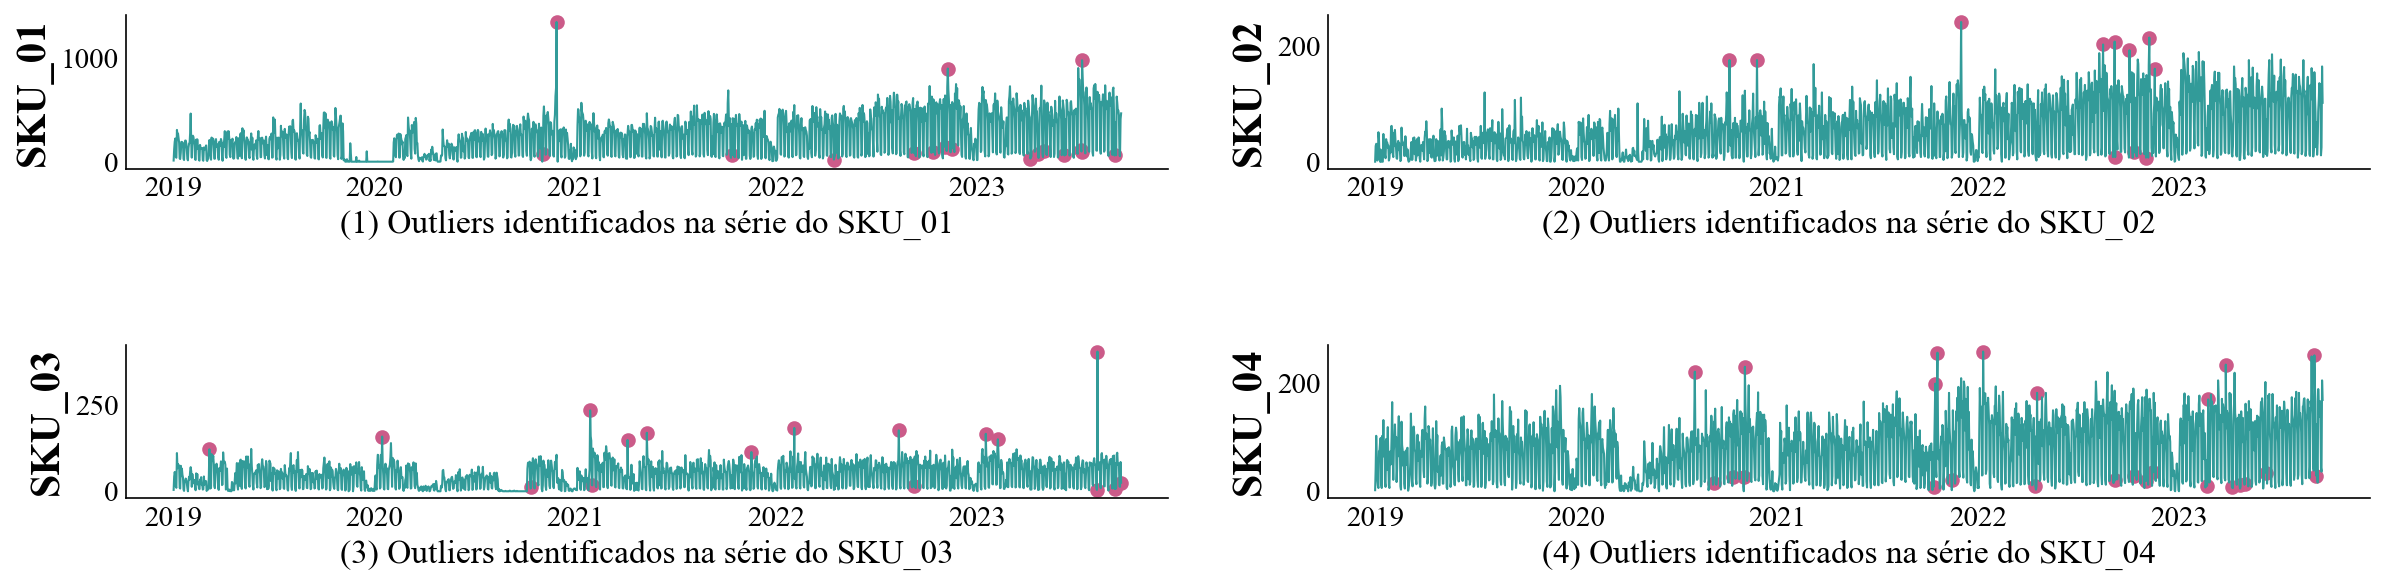

In [27]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 4),
)  
letters = string.ascii_lowercase
kwgs = dict(
    x='ds', y='y', color=colors[2]
)
for i, sku in zip([[0, 0],[0, 1],[1, 0],[1, 1]], df.unique_id.unique()):
    major_df = outliers_df[outliers_df['unique_id'] == sku]
    sns.lineplot(major_df, ax=ax[i[0], i[1]], lw=1, **kwgs)
    
    ax[i[0], i[1]].set_ylabel(sku, fontsize=20, weight='bold')
    ax[i[0], i[1]].set_xlabel(f'({i[0] + i[1] + i[0] + 1}) Outliers identificados na série do {sku}', fontsize=16)
   
    for outlier_col in ['min_outliers', 'max_outliers']:
        outliers = major_df[major_df[outlier_col] != 0]
        if not outliers.empty:
            ax[i[0], i[1]].scatter(outliers['ds'], outliers['y'], color="#cb5b89")
    
    for axs in (ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]):
        for j, spine in enumerate(axs.spines.values()):
            if j % 2 != 0:
                spine.set_visible(False)
        
        axs.tick_params(axis='x', labelsize=14, size=0, left=True)
        axs.tick_params(axis='y', labelsize=14, size=0)
    
fig.tight_layout(h_pad=5, w_pad=3)
plt.show()

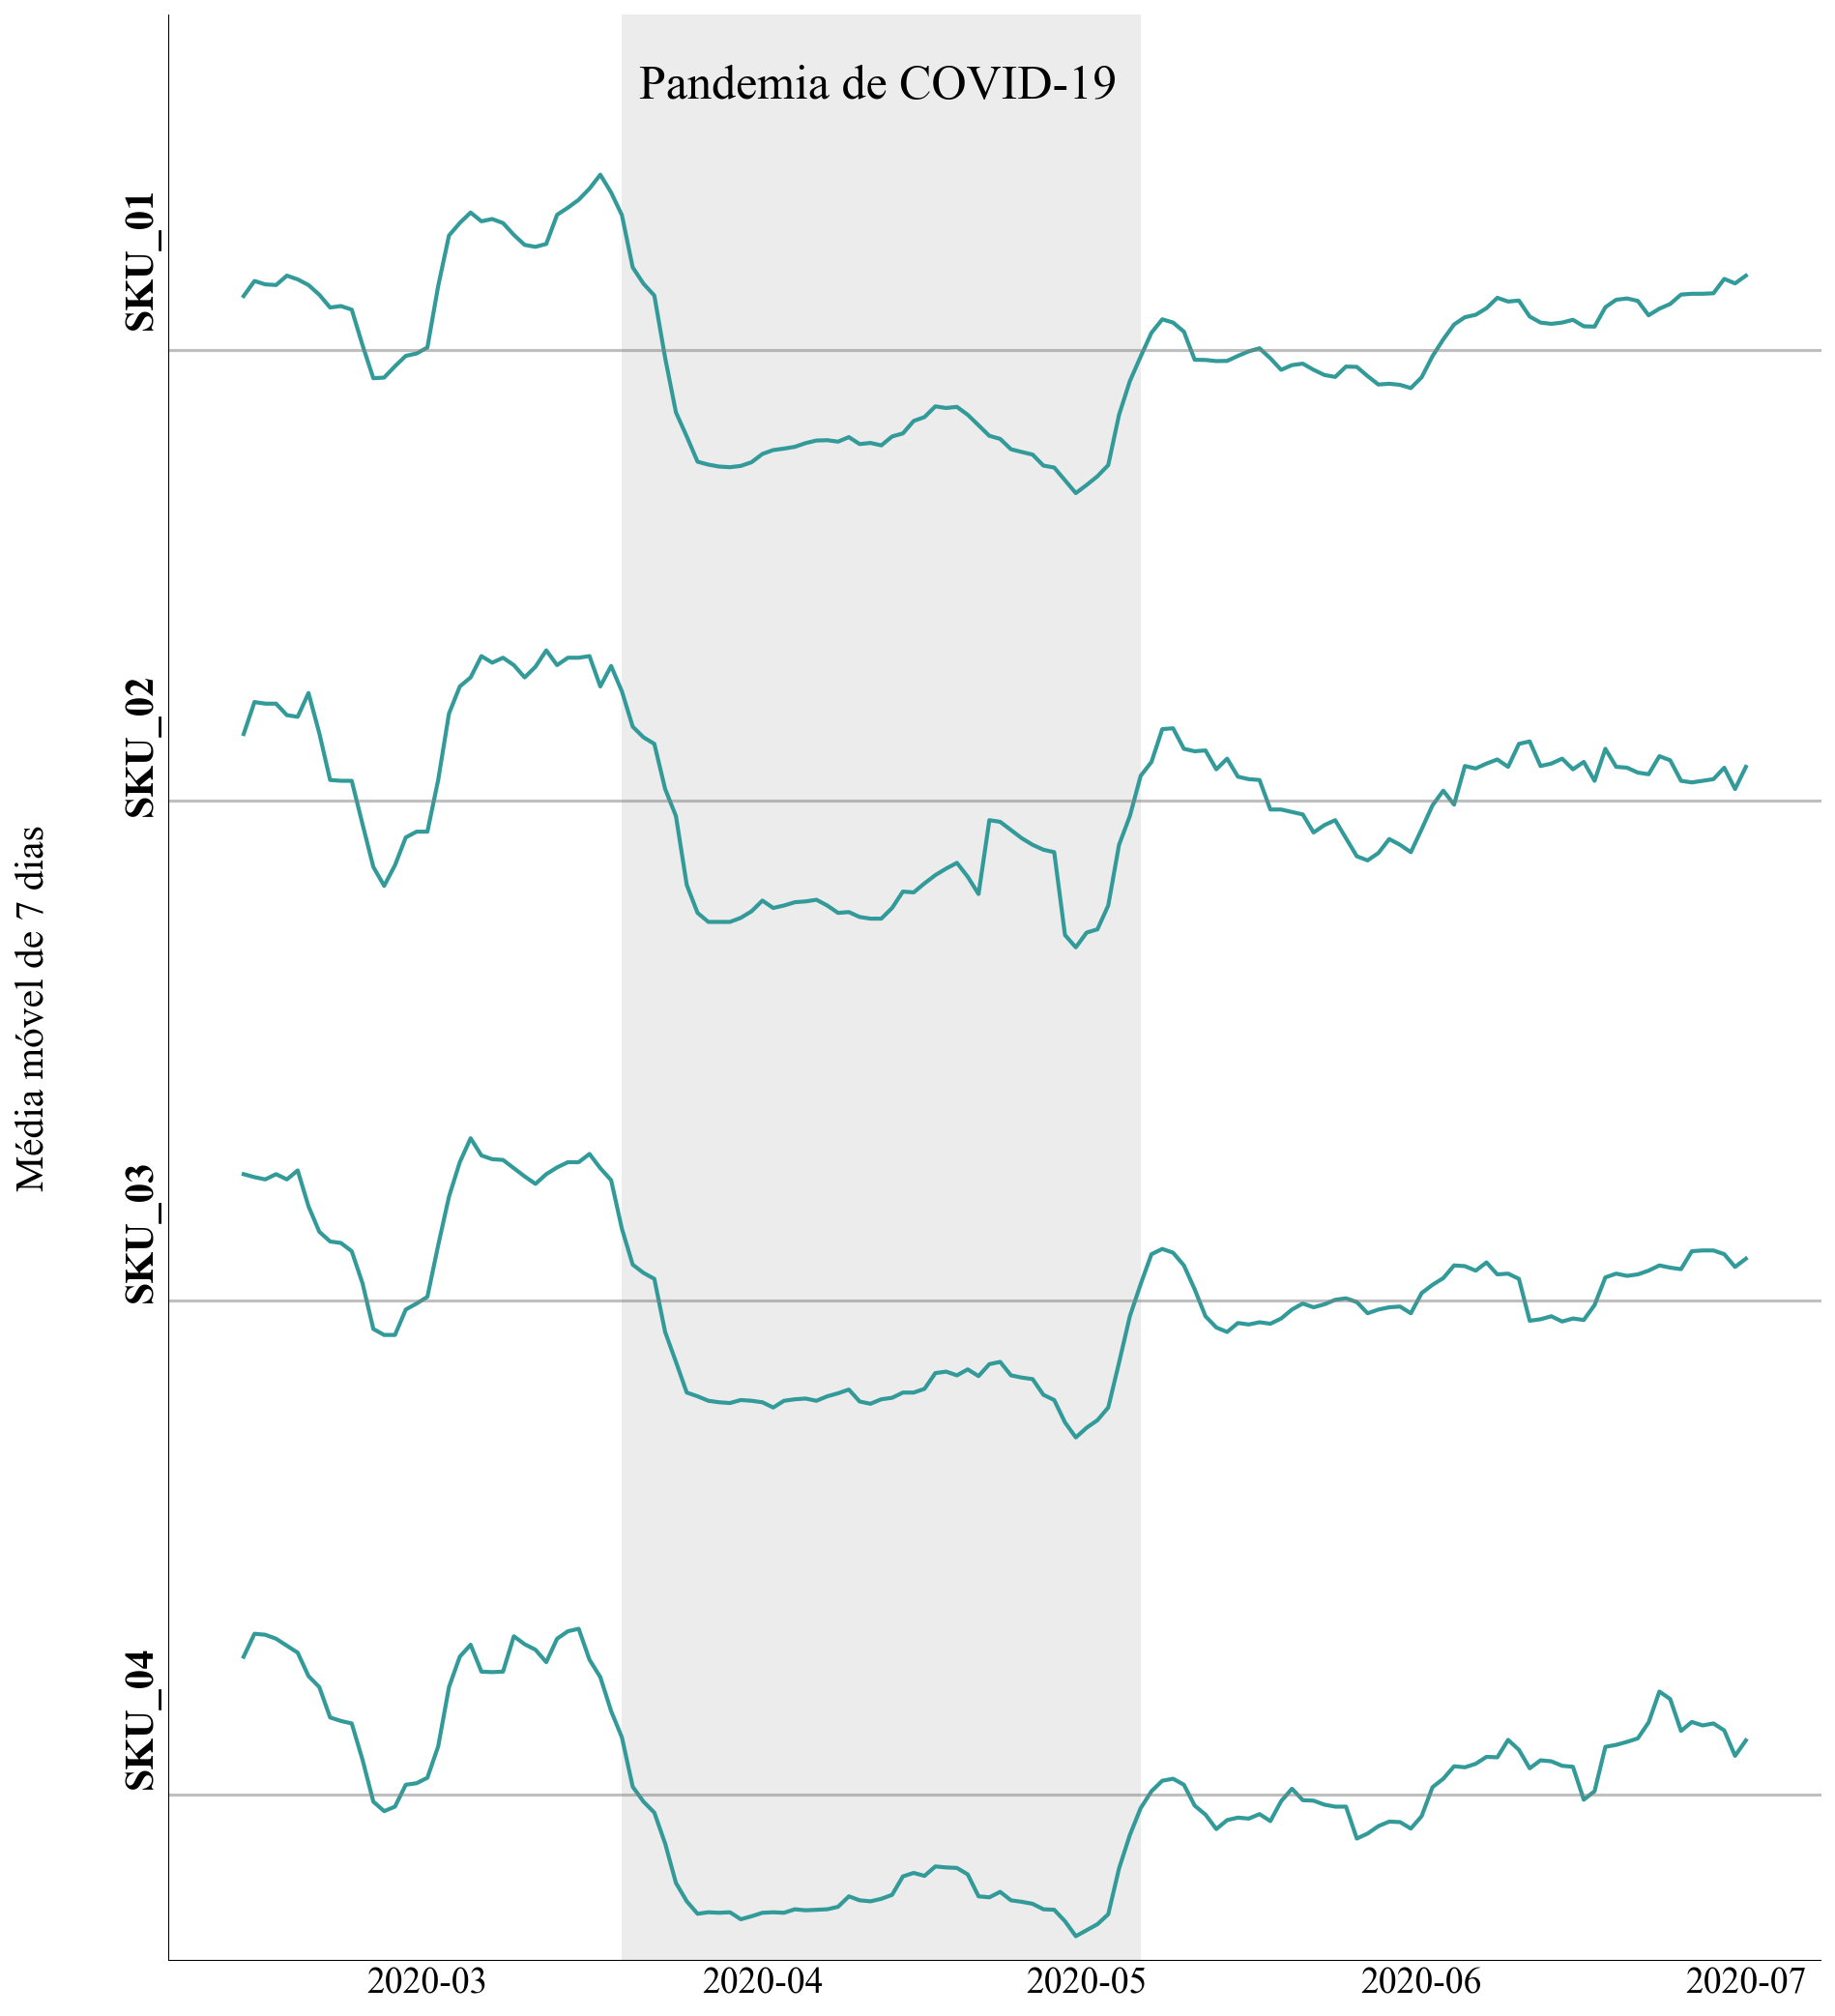

In [56]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 14),sharex=True)  
kwgs = dict(x='ds', y='y', color=colors[2])

start_date = pd.to_datetime('2020-03-19')
end_date = pd.to_datetime('2020-05-06')

for i, sku in enumerate(df.unique_id.unique()):
    major_df = df[df['unique_id'] == sku]\
            [(df['ds'] >= pd.to_datetime('2020-02-07')) 
             & (df['ds'] <= pd.to_datetime('2020-07-01'))
            ].set_index('ds').y.rolling(7).mean().reset_index()
    sns.lineplot(major_df, ax=ax[i], lw=2, **kwgs)
    
    ax[i].axhline(major_df.y.mean(), color='gray', linewidth=1.5, alpha=0.50)
    ax[i].set_ylim(major_df.y.min() - 7, major_df.y.max() * 1.5)
    ax[i].set_ylabel(sku, fontsize=20, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].axvspan(start_date, end_date, color='gray', alpha=0.15, lw=0)

for i, axs in enumerate(ax):
    for spine in axs.spines.values():
        spine.set_visible(False)
    axs.tick_params(axis='y', left=False, labelleft=False)
    if i == 3:
        axs.tick_params(axis='x', labelsize=18, size=0, left=True)
    else:
        axs.tick_params(axis='x', bottom=False, labelbottom=False)
        
for i in range(len(skus)):
    ax[i].add_line(Line2D([0, 0], [0, 1], transform=ax[i].transAxes, color='black', linewidth=1))
    
ax[0].text(start_date + (end_date - start_date) / 30, y=350, s='Pandemia de COVID-19', fontsize=24)
ax[-1].add_line(Line2D([0, 1], [0, 0], transform=ax[-1].transAxes, color='black', linewidth=1))

fig.text(-0.04, 0.5, 'Média móvel de 7 dias', rotation='vertical',
         va='center', ha='center', fontsize=20)

fig.tight_layout(h_pad=0, w_pad=0)
plt.subplots_adjust(hspace=0)
plt.show()
